# **Modelling and Evaluation Notebook Transfer Learning**

## Objectives

* Answer business requirement 1:
    * Write here your notebook objective, for example, "Fetch data from Kaggle and save as raw data", or "engineer features for modelling"

## Inputs

* inputs/brain-tumor-mri-dataset/mri-images/train
* inputs/brain-tumor-mri-dataset/mri-images/test
* inputs/brain-tumor-mri-dataset/mri-images/validation

## Outputs

* Images distribution plot in train, validation, and test set.
* Image augmentation.
* Class indices to change prediction inference in labels.
* Machine learning model creation and training.
* Save model.
* Learning curve plot for model performance.
* Model evaluation on pickle file.
* Prediction on the random image file.

## Additional Comments


---

## Import the regular packages

In [1]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.applications.vgg16 import VGG16

2024-10-25 11:16:09.165508: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-25 11:16:09.246383: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-25 11:16:09.249669: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-25 11:16:09.258563: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-25 11:16:09.353042: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [2]:
current_dir = os.getcwd()
current_dir

'/workspace/brain-tumor-detector/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
work_dir = os.getcwd()
work_dir

'/workspace/brain-tumor-detector'

## Set input directories
Set train, validation and test paths

In [5]:
my_data_dir = 'inputs/brain-tumor-mri-dataset/mri-images'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

---

# Set output directory

In [6]:
version = 'v3'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


Set labels

In [7]:
labels = os.listdir(train_path)

print(
    f"Project Labels: {labels}"
)

Project Labels: ['glioma', 'meningioma', 'notumor', 'pituitary']


Set image shape

In [8]:
## Import saved image shape embedding
import joblib
version = 'v3'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(150, 150, 3)

---

### Number of images in train, test and validation data

* train - glioma: 1134 images
* train - meningioma: 1151 images
* train - notumor: 1400 images
* train - pituitary: 1229 images
* validation - glioma: 162 images
* validation - meningioma: 164 images
* validation - notumor: 200 images
* validation - pituitary: 175 images
* test - glioma: 325 images
* test - meningioma: 330 images
* test - notumor: 400 images
* test - pituitary: 353 images




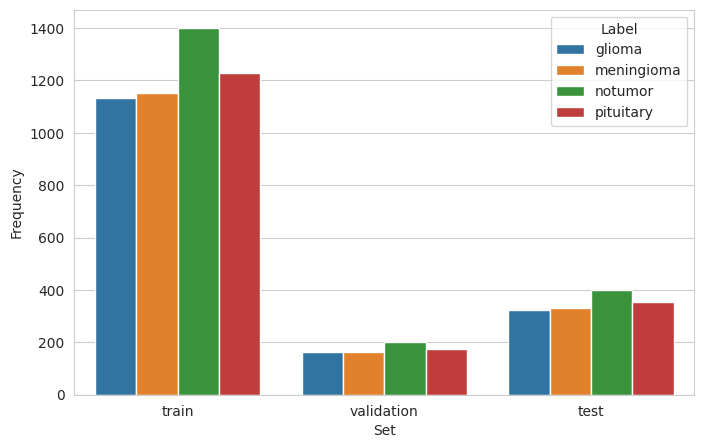

In [9]:
df_freq = pd.DataFrame([])
data_list = []

for folder in ['train', 'validation', 'test']:
    for label in labels:
        # Collect data in a list of dictionaries
        data_list.append({
            'Set': folder,
            'Label': label,
            'Frequency': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))
        })

        print(f"* {folder} - {label}: {len(os.listdir(my_data_dir + '/' + folder + '/' + label))} images")

# Convert list of dictionaries to a DataFrame
df_freq = pd.DataFrame(data_list)

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png', bbox_inches='tight', dpi=150)
plt.show()


---

## Image data augmentation


Initialize ImageDataGenerator

In [10]:
# Data augmentation and preprocessing
batch_size = 32
augmented_image_data = ImageDataGenerator(
                                        rescale=1./255,
                                        rotation_range=30,
                                        brightness_range=(0.8, 1.2),
                                        width_shift_range=0.1,
                                        height_shift_range=0.1,
                                        shear_range=15,
                                        zoom_range=0.1,
                                        channel_shift_range=0.2,
                                        horizontal_flip=True,
                                        vertical_flip=False,
                                        fill_mode="nearest")

In [11]:
# Data Preprocessing for Testing Data (without augmentation, only rescaling)
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(
                                                                test_path,
                                                                target_size=(150, 150),
                                                                batch_size=batch_size,
                                                                class_mode='categorical'
                                                            )

Found 1408 images belonging to 4 classes.


Augment training image dataset

In [12]:
# applying the generator to training data with constant seed
train_set = augmented_image_data.flow_from_directory(
                                                    train_path,
                                                    batch_size=batch_size,
                                                    target_size=image_shape[:2],
                                                    class_mode="categorical",
                                                    shuffle=True)
train_set.class_indices

Found 4914 images belonging to 4 classes.


{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

Augment validation image dataset

In [13]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        batch_size=batch_size,
                                                                        target_size=image_shape[:2],
                                                                        class_mode='categorical',
                                                                        shuffle=False)

validation_set.class_indices

Found 701 images belonging to 4 classes.


{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

Plot augmented training image

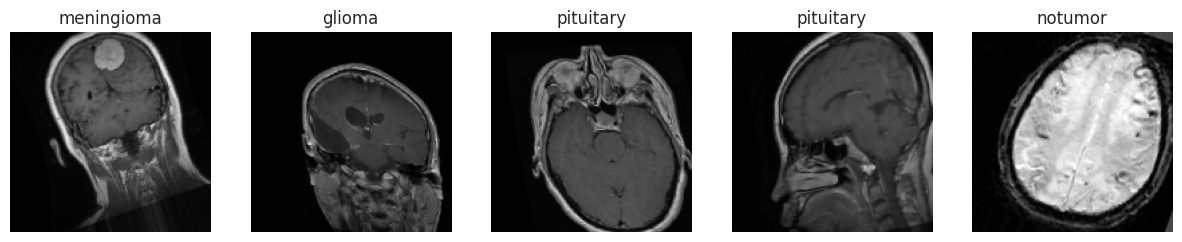

In [15]:
# Get a batch of images from the generator
x_batch, y_batch = next(train_set)  # Extract the first batch of augmented images

# Display the first 5 images
plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.title(list(train_set.class_indices.keys())[np.argmax(y_batch[i])])  # Display the class name
    plt.imshow(x_batch[i])
    plt.axis('off')
plt.show()



Plot augmented validation images

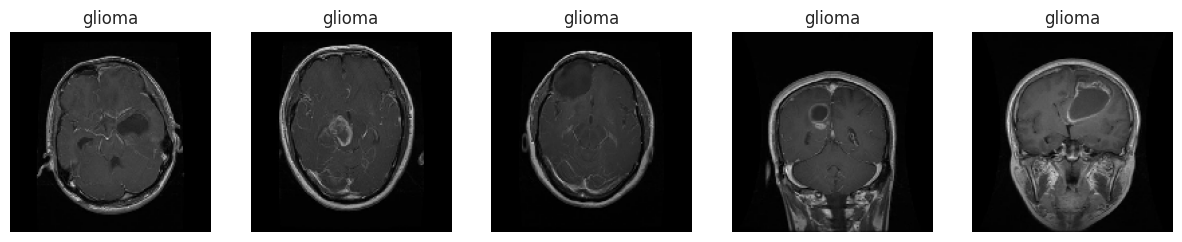

In [16]:
# Get a batch of images from the generator
x_batch, y_batch = next(validation_set)  # Extract the first batch of augmented images

# Display the first 5 images
plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.title(list(validation_set.class_indices.keys())[np.argmax(y_batch[i])])
    plt.imshow(x_batch[i])
    plt.axis('off')
plt.show()


Plot augmented test images

### Save class_indices

In [14]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v3/class_indices.pkl']

---

## Model creation

### ML model
Import model packages

In [15]:
import tensorflow
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, Input, BatchNormalization
from tensorflow.keras.regularizers import l2

Model

Creating an object of VGG16 Model to use it as a pretrained model

In [16]:
conv_base = VGG16(
    weights='imagenet', # weight of the trained model
    include_top = False, # disables the Dense layers and output layer
    input_shape=image_shape
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Freez the Trainable parameters of the trained model

In [17]:
conv_base.trainable = False

In [18]:
conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

for layer in conv_base.layers:
  print(layer.name,layer.trainable)

input_layer False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


show the summary of the model

In [19]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 7,079,424 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [20]:
# Data Classifications
CLASS_TYPES = ['pituitary', 'notumor', 'meningioma', 'glioma']
N_TYPES = len(CLASS_TYPES)

In [21]:
def create_tf_model():
    model = Sequential()

    model.add(conv_base)
    model.add(Flatten())
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(N_TYPES, activation="softmax"))

    optimizer=keras.optimizers.RMSprop(learning_rate=1e-5)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics= ['accuracy'])

    return model

In [22]:
# Call the function and display the model summary
model = create_tf_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,763,908 (60.13 MB)

 Trainable params: 8,128,644 (31.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

/workspace/.pyenv_mirror/user/current/lib/python3.12/site-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


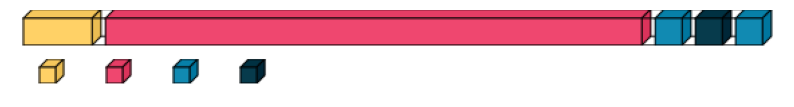

In [27]:
import visualkeras

# Visualize the model
model_str = visualkeras.layered_view(model, legend=True, max_xy=300, legend_text_spacing_offset=20)

plt.figure(figsize=(10, 10))
plt.imshow(model_str)
plt.axis('off')

plt.savefig(f'{file_path}/model_visualization.png', bbox_inches='tight', dpi=150)

plt.show()

plt.close()

Early Stopping

In [28]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Stop training if loss doesn't keep decreasing.
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-9, patience=5, restore_best_weights=True, verbose=True)
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=True)


Fit model for model training

In [29]:
model = create_tf_model()
model.fit(train_set,
          epochs=15,
          validation_data=validation_set,
          callbacks=[early_stop, model_rlr])

/workspace/.pyenv_mirror/user/current/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 552s 4s/step - accuracy: 0.5006 - loss: 1.1289 - val_accuracy: 0.8274 - val_loss: 0.5299 - learning_rate: 1.0000e-05
Epoch 2/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 545s 4s/step - accuracy: 0.7714 - loss: 0.6088 - val_accuracy: 0.8459 - val_loss: 0.4362 - learning_rate: 1.0000e-05
Epoch 3/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 551s 4s/step - accuracy: 0.8136 - loss: 0.5079 - val_accuracy: 0.8688 - val_loss: 0.3782 - learning_rate: 1.0000e-05
Epoch 4/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 547s 4s/step - accuracy: 0.8449 - loss: 0.4202 - val_accuracy: 0.8830 - val_loss: 0.3464 - learning_rate: 1.0000e-05
Epoch 5/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 549s 4s/step - accuracy: 0.8599 - loss: 0.3951 - val_accuracy: 0.8902 - val_loss: 0.3404 - learning_rate: 1.0000e-05
Epoch 6/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 555s 4s/step - accuracy: 0.8701 - loss: 0.3542 - val_accuracy: 0.8845 - val_loss: 0.3318 - learning_rate: 1.0000e-05
Epoch 7/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 549s 4s/step - acc

saving the


In [30]:
model.save('outputs/v3/brain_tumor_detector.keras')


## Model Performace

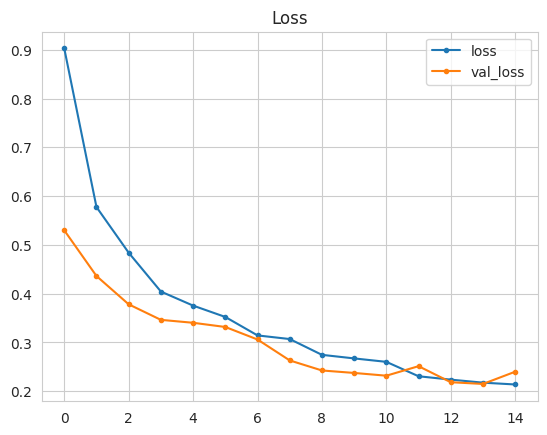

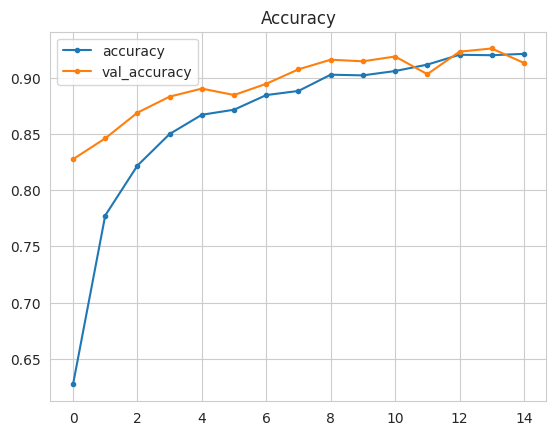

In [31]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()

## Model Evaluation
Load saved model

In [32]:
from tensorflow.keras.models import load_model

# Reload the model to ensure fresh state
model = load_model('outputs/v3/brain_tumor_detector.keras')

Evaluate model on test set

In [33]:
# Evaluating the model
loss, accuracy = model.evaluate(test_set, steps=test_set.samples // batch_size)
print(f"Test Loss: {loss:.5f}")
print(f"Test Accuracy: {accuracy:.5f}")

/workspace/.pyenv_mirror/user/current/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


44/44 ━━━━━━━━━━━━━━━━━━━━ 122s 3s/step - accuracy: 0.9305 - loss: 0.1820
Test Loss: 0.20317
Test Accuracy: 0.92756


Save evaluation pickle

In [34]:
# Saving the evaluation results in a dictionary
evaluation = {
    'loss': loss,
    'accuracy': accuracy
}

# Saving the evaluation results using joblib
joblib.dump(value=evaluation, filename="outputs/v3/evaluation.pkl")

['outputs/v3/evaluation.pkl']

## Predict on new data
Load a random image as PIL

Class name of the first image: notumor
Shape (1, 150, 150, 3)


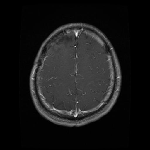

In [35]:
from tensorflow.keras.preprocessing.image import array_to_img

# Get the next batch from the test generator
batch_images, batch_labels = next(test_set)

# Extract the first image from the batch
image, label = batch_images[3], batch_labels[0]
image_tensor = np.expand_dims(image, axis=0)

# Get the class indices from the test set
class_indices = test_set.class_indices

# Convert the one-hot encoded label to the class name
label_name = [k for k, v in class_indices.items() if np.argmax(label) == v][0]

# Display the class name
print(f"Class name of the first image: {label_name}")
print(f'Shape {image_tensor.shape}')

# Display the image
array_to_img(image_tensor[0])


## confusion matrix

44/44 ━━━━━━━━━━━━━━━━━━━━ 118s 3s/step


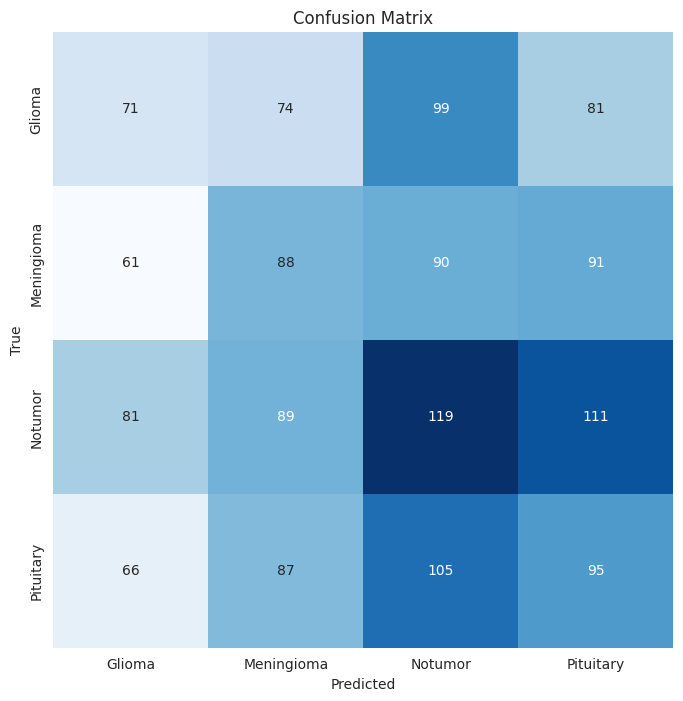

In [36]:
from sklearn.metrics import confusion_matrix as sklearn_confusion_matrix

# Make predictions on the test set
predictions = model.predict(test_set, steps=test_set.samples // batch_size)
predicted_classes = np.argmax(predictions, axis=1)

# Get true classes from test set
true_classes = test_set.classes

# Get class names
class_indices_train_list = list(train_set.class_indices.keys())

# Compute confusion matrix
cm = sklearn_confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(len(class_indices_train_list)) + 0.5,
           labels=[name.title() for name in class_indices_train_list], ha='center')
plt.yticks(ticks=np.arange(len(class_indices_train_list)) + 0.5,
           labels=[name.title() for name in class_indices_train_list], va='center')

plt.savefig('outputs/v3/confusion_matrix.png', bbox_inches='tight', dpi=150)

plt.show()



NOTE

---

# Push files to Repo